In [5]:
import pybliometrics
pybliometrics.scopus.init()
import requests
import pandas as pd
import time
import os
import json
from datetime import datetime


In [288]:
## Fetch data form SCOPUS API ##

base_url = "https://api.elsevier.com/content/search/scopus"
api_key = "121d535338908f1887297b3349c4a714"

# Define the base search parameters
params = {
    'apiKey': api_key,
    'count': 25,  # Number of results per page (max allowed by SCOPUS API)
    'view': 'STANDARD',
}

# Function to fetch and process data from SCOPUS API for a specific year
def fetch_data_for_year(year, start_index=0, max_records=5500):
    retries = 3
    delay = 5
    query = f"PUBYEAR = {year}"
    params['query'] = query

    records_fetched = 0
    result_data = []  # Temporary storage for this year's data

    while records_fetched < max_records:
        params['start'] = start_index  # Update start index for pagination
        for attempt in range(retries):
            try:
                response = requests.get(base_url, params=params)
                response.raise_for_status()  # Raise an exception for HTTP errors

                if response.status_code == 200:
                    data = response.json()
                    entries = data.get('search-results', {}).get('entry', [])

                    for entry in entries:
                        title = entry.get('dc:title', 'No title available')
                        authors = entry.get('dc:creator', 'No authors available')
                        year = entry.get('prism:coverDate', 'No date available')[:4]
                        journal = entry.get('prism:publicationName', 'Unknown Journal')
                        language = entry.get('language', 'Unknown Language')
                        cited_by_count = entry.get('citedby-count', '0')

                        affiliation = "; ".join(
                            aff.get('affilname', 'Unknown Affiliation')
                            for aff in entry.get('affiliation', [])
                        )

                        result_data.append({
                            'Title': title,
                            'Authors': authors,
                            'Year': year,
                            'Journal': journal,
                            'Language': language,
                            'CitedByCount': cited_by_count,
                            'Affiliation': affiliation,
                        })

                    records_fetched += len(entries)
                    start_index += params['count']
                    print(f"Fetched {records_fetched} records for {year}...")
                    if records_fetched >= max_records:
                        break
                else:
                    print(f"Error {response.status_code}: {response.text}")
                    return result_data

            except requests.exceptions.RequestException as e:
                print(f"Attempt {attempt + 1} failed with error: {e}")
                if attempt < retries - 1:
                    time.sleep(delay)
                else:
                    print("Max retries reached. Skipping this request.")
                    return result_data

    return result_data


In [ ]:
## Specify the year to fetch data seperately and convert it into CSV ##
year = 2018 #(change until reaching 2023)

# Fetch data for the given year
year_data = fetch_data_for_year(year)

# Save the fetched data to a CSV file
year_df = pd.DataFrame(year_data)
df = year_df.drop(columns='Language')

# Drop null and duplicate values
df = df.dropna()
df = df.drop_duplicates()

year_df.to_csv(f'scopus_data_{year}.csv', index=False)

df

In [ ]:
# combined all CSV from 2018–2023 into a single CSV
csv_files = [
    'scopus_data_2018.csv',
    'scopus_data_2019.csv',
    'scopus_data_2020.csv',
    'scopus_data_2021.csv',
    'scopus_data_2022.csv',
    'scopus_data_2023.csv',
]

# Combine all CSV files into a single DataFrame
combined_df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('scopus_combined_data_2018_2023.csv', index=False)

In [7]:
## example of cleaned global dataframe ##

global_df = pd.read_csv('scopus_combined_data_2018_2023.csv')

global_df

,Title,Authors,Year,Journal,Language,CitedByCount,Affiliation
0,Social Progress for Resilient Regions,van Ballekom P.,2018,Region,Unknown Language,0,European Investment Bank
2,Fashion language and translatology,Bojović B.,2018,Babel,Unknown Language,0,University of Montenegro
3,A pragmatic framework to note-taking in consec...,Abuarrah S.,2018,Babel,Unknown Language,0,An-Najah National University
4,An Analytic Approximation to the Density of Tw...,Azura R.B.,2018,Recoletos Multidisciplinary Research Journal,Unknown Language,0,Agusan del Sur State College of Agriculture an...
5,DANCE MOTIFS ON PREHISTORIC POTTERY FROM EASTE...,Turčin I.,2018,Vjesnik Arheoloskog Muzeja u Zagrebu,Unknown Language,0,Centre for Experimental Archaeology
...,...,...,...,...,...,...,...
30045,Second pleurectomy/decortication for a contral...,Furia S.,2023,AME Medical Journal,Unknown Language,0,Ospedale dell’Angelo
30046,Driving change and quality care in a healthcar...,Cerfolio R.J.,2023,Video-Assisted Thoracic Surgery,Unknown Language,0,NYU Langone Health
30047,Nephron-sparing surgery for small renal masses...,Gomes D.C.,2023,AME Medical Journal,Unknown Language,0,A.C.Camargo Cancer Center
30048,From video-assisted mediastinoscopy (VAM) to v...,Martínez S.,2023,Video-Assisted Thoracic Surgery,Unknown Language,0,Centro de Tratamiento e Investigación sobre Cá...


In [9]:
## trend model to predict subject area of each research ##

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

# using data from chula_data
data = pd.read_csv("full_Chula_data.csv").drop(columns="Cover-Date")

# Preprocessing
X = data['Publication Name'] + " " + data['Title']  # Combine text columns
y = data['Subject Area'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)  # Split string back to list

# Convert the text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
X_vect = vectorizer.fit_transform(X)

# MultiLabelBinarizer to handle multi-label classification
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)  # Transform multi-label data into binary format

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vect, y_bin, test_size=0.2, random_state=42)

# Model: RandomForest with One-vs-Rest strategy
model = OneVsRestClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)

# Predict probabilities on the test set (for thresholding)
y_prob = model.predict_proba(X_test)

# Initialize a matrix for thresholded predictions
y_pred_thresholded = np.zeros(y_prob.shape)

# Initialize list to store thresholds for each class
thresholds_list = []

# For each class, optimize the threshold based on precision-recall curve
for i in range(y_prob.shape[1]):
    precision, recall, thresholds = precision_recall_curve(y_test[:, i], y_prob[:, i])
    
    # Calculate F1-score for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Choose the threshold based on the maximum F1-score
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Append the best threshold for this class to the list
    thresholds_list.append(best_threshold)
    
    # Apply the best threshold for this class
    y_pred_thresholded[:, i] = (y_prob[:, i] >= best_threshold).astype(int)

# Evaluation: Use classification_report for detailed metrics
print("Evaluation with fine-tuned thresholding:")
print(classification_report(y_test, y_pred_thresholded, target_names=mlb.classes_))

# Now, you can save the thresholds_list for later use:
# Example: Save thresholds_list to use later (if you need it for new predictions)


Evaluation with fine-tuned thresholding:
              precision    recall  f1-score   support

        AGRI       0.89      0.79      0.84       378
        ARTS       0.92      0.74      0.82       104
        BIOC       0.81      0.73      0.77       481
        BUSI       0.73      0.81      0.77       133
        CENG       0.87      0.82      0.84       312
        CHEM       0.84      0.86      0.85       444
        COMP       0.90      0.90      0.90       368
        DECI       0.86      0.65      0.74        78
        DENT       0.98      0.91      0.94        97
        EART       0.87      0.67      0.75       126
        ECON       0.78      0.67      0.72        81
        ENER       0.90      0.80      0.84       205
        ENGI       0.88      0.82      0.85       586
        ENVI       0.85      0.83      0.84       362
        HEAL       0.72      0.56      0.63        70
        IMMU       0.85      0.77      0.81       232
        MATE       0.87      0.88      0

/Users/im/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


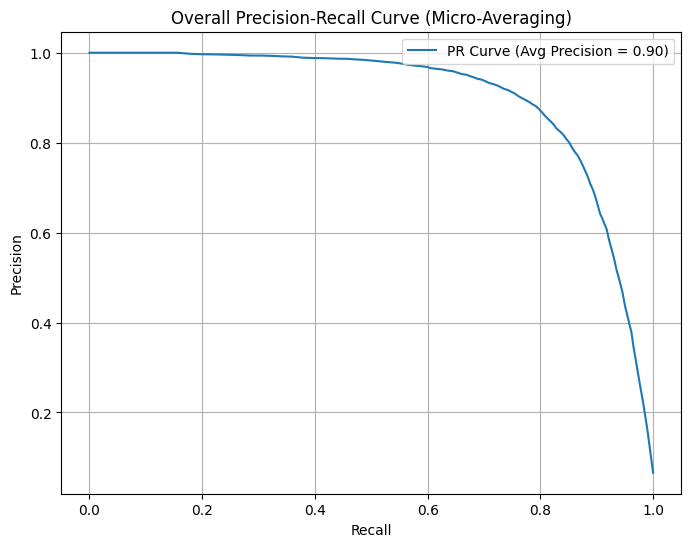

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
# Flatten the true and predicted probabilities for micro-averaging
y_test_flat = y_test.ravel()
y_prob_flat = y_prob.ravel()

# Compute precision, recall, and thresholds for micro-averaged PR curve
precision, recall, thresholds = precision_recall_curve(y_test_flat, y_prob_flat)

# Calculate average precision (area under the PR curve)
avg_precision = average_precision_score(y_test_flat, y_prob_flat)

# Plot the overall precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Overall Precision-Recall Curve (Micro-Averaging)')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
## use the model to predicted subject area of each research in global_df ##

# Step 1: Vectorize the new data

new_df = global_df
X_new = new_df['Journal'] + " " + new_df['Title']
X_new_vect = vectorizer.transform(X_new)

# Step 2: Predict probabilities using the trained model
y_new_prob = model.predict_proba(X_new_vect)

# Step 3: Apply thresholds and fallback strategies
y_new_pred_thresholded = np.zeros(y_new_prob.shape)

# Relaxed thresholds to reduce "No Prediction"
relaxation_factor = 0.9  # Adjust this factor as needed
for i in range(y_new_prob.shape[1]):
    relaxed_threshold = thresholds_list[i] * relaxation_factor
    y_new_pred_thresholded[:, i] = (y_new_prob[:, i] >= relaxed_threshold).astype(int)

# Step 4: Convert predictions to labels with fallback
y_new_pred = []
for row, prob_row in zip(y_new_pred_thresholded, y_new_prob):
    if np.all(row == 0):  # No prediction
        # Fallback: Choose top 2 probabilities as labels
        top_indices = np.argsort(prob_row)[-2:]  # Top 2 probabilities
        fallback_labels = mlb.classes_[top_indices]
        y_new_pred.append(list(fallback_labels))
    else:
        # Ensure 'row' is a 2D array when passed to `inverse_transform`
        row_array = np.array(row).reshape(1, -1)
        y_new_pred.append(mlb.inverse_transform(row_array)[0])

# Step 5: Add predictions to the DataFrame
new_df['Predicted Subject Area'] = [
    ', '.join(labels) if labels else 'No Prediction' for labels in y_new_pred
]

# Step 6: Count and analyze results
no_prediction_count = new_df['Predicted Subject Area'].value_counts().get('No Prediction', 0)
print(f"Number of 'No Prediction': {no_prediction_count} out of {len(new_df)}")

# Display the updated DataFrame
new_df
new_df = new_df.reset_index(drop=True)
new_df.to_csv("global_data_with_predicted_area (2018-2023).csv", index=False)

new_df

Number of 'No Prediction': 0 out of 9657


,Title,Authors,Year,Journal,Language,CitedByCount,Affiliation,Predicted Subject Area
0,Social Progress for Resilient Regions,van Ballekom P.,2018,Region,Unknown Language,0,European Investment Bank,SOCI
1,Fashion language and translatology,Bojović B.,2018,Babel,Unknown Language,0,University of Montenegro,"ARTS, SOCI"
2,A pragmatic framework to note-taking in consec...,Abuarrah S.,2018,Babel,Unknown Language,0,An-Najah National University,"ECON, SOCI"
3,An Analytic Approximation to the Density of Tw...,Azura R.B.,2018,Recoletos Multidisciplinary Research Journal,Unknown Language,0,Agusan del Sur State College of Agriculture an...,"MEDI, ENGI"
4,DANCE MOTIFS ON PREHISTORIC POTTERY FROM EASTE...,Turčin I.,2018,Vjesnik Arheoloskog Muzeja u Zagrebu,Unknown Language,0,Centre for Experimental Archaeology,"SOCI, ARTS"
...,...,...,...,...,...,...,...,...
9652,Second pleurectomy/decortication for a contral...,Furia S.,2023,AME Medical Journal,Unknown Language,0,Ospedale dell’Angelo,MEDI
9653,Driving change and quality care in a healthcar...,Cerfolio R.J.,2023,Video-Assisted Thoracic Surgery,Unknown Language,0,NYU Langone Health,MEDI
9654,Nephron-sparing surgery for small renal masses...,Gomes D.C.,2023,AME Medical Journal,Unknown Language,0,A.C.Camargo Cancer Center,"BIOC, MEDI"
9655,From video-assisted mediastinoscopy (VAM) to v...,Martínez S.,2023,Video-Assisted Thoracic Surgery,Unknown Language,0,Centro de Tratamiento e Investigación sobre Cá...,MEDI


In [34]:
## Number of researchs based on predicted subject areas in each year ##

new_df['Predicted Subject Area'] = new_df['Predicted Subject Area'].str.split(', ')  # Split multi-label entries into lists
exploded_df = new_df.explode('Predicted Subject Area')  # Explode the lists into separate rows
# Group by 'Year' and 'Predicted Subject Area', then count the occurrences
subject_area_count = exploded_df.groupby(['Year', 'Predicted Subject Area']).size().reset_index(name='Count')

test = subject_area_count.groupby(['Year', 'Predicted Subject Area'])['Count'].sum().reset_index()

# Pivot the table to have 'Year' as the index and subject areas as columns
pivoted_df = test.pivot_table(index='Year', columns='Predicted Subject Area', values='Count', aggfunc='sum')

pivoted_df.to_csv("AreasCount_GlobalData.csv", index=True)
# Display the result
pivoted_df



Predicted Subject Area,AGRI,ARTS,BIOC,BUSI,CENG,CHEM,COMP,DECI,DENT,EART,...,MATH,MEDI,MULT,NEUR,NURS,PHAR,PHYS,PSYC,SOCI,VETE
Year,,,,,,,,,,,,,,,,,,,,,
2018,95,55,88,64,77,158,490,49,6,119,...,49,202,4,14,2,26,131,7,148,5
2019,150,123,134,44,54,102,102,6,6,117,...,66,396,15,23,13,41,196,13,246,10
2020,136,166,126,34,26,85,82,1,17,41,...,56,425,33,25,23,29,105,17,350,11
2021,157,161,139,56,55,100,107,5,7,39,...,109,504,63,16,21,53,142,34,310,13
2022,166,239,166,76,65,88,103,4,4,50,...,56,323,36,15,15,32,91,28,508,27
2023,149,170,432,46,18,70,136,5,5,42,...,73,362,17,9,17,66,56,15,277,3


In [7]:

area_df = pd.read_csv("global_data_with_predicted_area (2018-2023).csv")
area_df = area_df.assign(Area=area_df['Predicted Subject Area'].str.split(', ')).explode('Area')

# Group by Area and Affiliation, aggregate Count and TotalCitedByCount
area_affiliation_stats = (
    area_df.groupby(['Area', 'Affiliation'])
    .agg(Count=('Title', 'size'), TotalCitedByCount=('CitedByCount', 'sum'))
    .reset_index()
)

# Normalize Count
min_count = area_affiliation_stats['Count'].min()
max_count = area_affiliation_stats['Count'].max()
area_affiliation_stats['Normalized Count'] = (
    area_affiliation_stats['Count'] - min_count
) / (max_count - min_count)

# Normalize TotalCitedByCount
min_cited = area_affiliation_stats['TotalCitedByCount'].min()
max_cited = area_affiliation_stats['TotalCitedByCount'].max()
area_affiliation_stats['Normalized TotalCitedByCount'] = (
    area_affiliation_stats['TotalCitedByCount'] - min_cited
) / (max_cited - min_cited)


w1 = 0.7  # Weight for Count
w2 = 0.3  # Weight for TotalCitedByCount

# Calculate weighted score
area_affiliation_stats['Score'] = w1 * area_affiliation_stats['Normalized Count'] + w2 * area_affiliation_stats['Normalized TotalCitedByCount']

# Sort and retrieve the top recommendations for each area
top_recommendations = (
    area_affiliation_stats
    .sort_values(['Area', 'Score'], ascending=[True, False])
    .groupby('Area')
    .head(5)
)


bioc = top_recommendations[top_recommendations['Area'] == 'BIOC']
ener = top_recommendations[top_recommendations['Area'] == 'ENER']
econ = top_recommendations[top_recommendations['Area'] == 'ECON']

# Combine the filtered dataframes
combined = pd.concat([bioc, ener, econ])

# Save the combined dataframe to a CSV file
combined.to_csv("top_recommendations.csv", index=False)

combined


,Area,Affiliation,Count,TotalCitedByCount,Normalized Count,Normalized TotalCitedByCount,Score
1431,BIOC,Jiangnan University,12,71,0.379310,0.108729,0.298136
1617,BIOC,Poznan University of Medical Sciences,11,20,0.344828,0.030628,0.250568
1173,BIOC,Beijing Forestry University,8,34,0.241379,0.052067,0.184586
1443,BIOC,Jilin University,6,19,0.172414,0.029096,0.129419
1500,BIOC,Lovely Professional University,6,3,0.172414,0.004594,0.122068
4781,ENER,Jiangnan University,8,48,0.241379,0.073507,0.191018
4704,ENER,Centre de Développement des Energies Renouvela...,7,10,0.206897,0.015314,0.149422
4689,ENER,Beijing Forestry University,5,17,0.137931,0.026034,0.104362
4971,ENER,Université de Batna 1,5,1,0.137931,0.001531,0.097011
5001,ENER,Zhengzhou University,4,46,0.103448,0.070444,0.093547
